In [1]:
import numpy as np
import pandas as pd
from math import sin
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


- Maximize the log probability of y given the parameters of the kernel
- Reference: https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co/1072701#1072701
- $lnP(y|x,θ)=−1/2*ln|K|−1/2*ytK−1y−N2ln2π$

- Define the kernel

In [15]:
def rbf( a, b, length=2.0, train=False,
                            train_noise = 5e-3, theta=1.5):
        """Calculated the squarred exponential kernel.
        Adds a noise term for the covariance of the training data
        Adjusting the length changes the difference where points will have a positive covariance
        Returns a covaraince Matrix.
        Vertical scale controls the vertical scale of the function"""


        if train == False:
            # ensure a and b are numpy arrays
            a = np.array(a)
            b = np.array(b)
            sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
            return theta*np.exp(-.5 * (1/length) * sqdist)

        else:
            # ensure a and b are numpy arrays
            a = np.array(a)
            b = np.array(b)
            noisy_observations = train_noise*np.eye(len(a))
            sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
            return theta*np.exp(-.5 * (1/length) * sqdist) + noisy_observations

- Define the RBF gradients

In [16]:
def rbf_grad_theta(a,b, theta = 1.5, length = 2.0):
    """Computes the derivative of the RBF kernel wrt the theta parameter.
    Only use with the training points (points that have a corresponding y-value)"""
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)

    return 2*theta*np.exp( - sqdist / (2*length**2 ))

In [17]:
def rbf_grad_length(a,b, theta = 1.5, length = 2.0 ):
    """COmputes the derivative of the RBF kernel wrt the length parameter.
    Only use with the training points (points that have a corresponding y-value
    """
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    
    return theta**2 * np.exp(-sqdist / (2*length**2)  )* ( sqdist / length**3)

- Define test points

In [18]:
test_x = np.array(np.linspace(-100,100,1_000)).reshape(-1,1)
train_x = np.array([[-5,10,40]]).reshape(-1,1)

train_y_func = lambda x: 1000*sin(.1*x)/abs(x+10*x+5)
train_y_func_two_d = lambda a,b : (a*b)/(a-1/(b+1)) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = 100
max_covariance = 5


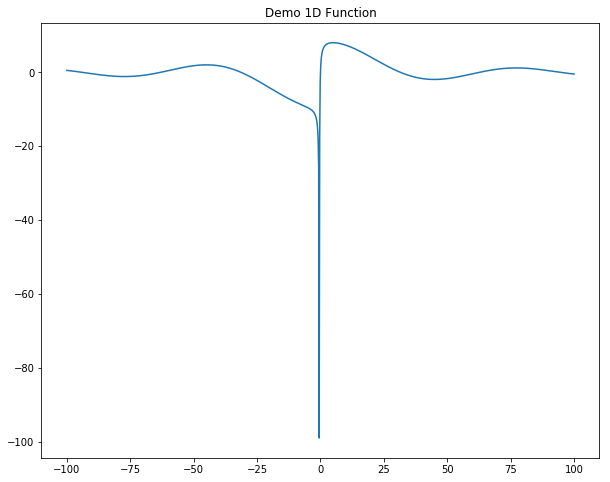

In [19]:
plt.figure(figsize=(10,8))
plt.title('Demo 1D Function')
plt.plot(np.linspace(-100,100,1_000),np.array([train_y_func(_) for _ in test_x]).reshape(-1,1) );

### Test the gradients
- returns a matrix of first derivatives

In [20]:
rbf_grad_theta(train_x,test_x)

array([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          4.40835314e-193,   2.22134600e-194,   1.10816492e-195]])

In [21]:
rbf_grad_length(train_x,test_x)

array([[  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
          1.46802800e-190,   7.44709589e-192,   3.74005661e-193]])

# Define the gradient of the marginal log-likelihood and the marginal log-likelihood

In [22]:
def marginal_log_likehood_grad(covariance_matrix, y_values, cov_gradient_matrix):
    """
    covaraince_matrix: the covaraince given the kernel 
    y_values: returning y-vals from the underlying function
    cov_gradient_matrix: the jacobian matrix for the given parameter
    
    return the gradient of the marginal log-likelihood"""
    
    return 1/2 * y_values.T @ np.linalg.inv(covariance_matrix) @  cov_gradient_matrix @np.linalg.inv(covariance_matrix)\
            @ y_values -\
            .5* np.trace(np.linalg.inv(covariance_matrix) @ cov_gradient_matrix)

In [23]:
def marginal_log_likehood(covariance_matrix, y_values):
    """Return the marginal likelihood of the y-values over the latent variables"""
    from math import pi
    return -.5*np.log(abs(covariance_matrix))- (.5*y_values.T @ np.linalg.inv(covariance_matrix) @ y_values)  - \
        len(y_values)/2*np.log(2*pi)

In [24]:
cov_train_train = rbf(train_x,train_x)

In [25]:
length_grad = rbf_grad_length(train_x,train_x)
theta_grad = rbf_grad_theta(train_x,train_x)

In [26]:
marginal_log_likehood_grad(cov_train_train,train_y_numbers, length_grad )

array([[ -1.20407265e-09]])

In [27]:
marginal_log_likehood_grad(cov_train_train,train_y_numbers, theta_grad  )

array([[ 95.91491574]])

## Hill climbing optimization

In [42]:
original_theta = 1.5
original_length = 5
learning_rate = .1
thetas = []
lengths = []
marginal_likelihood_nums = []

for i in range(200):
    if i == 0:
        cov_train_train = rbf(train_x,train_x , theta=original_theta, length = original_length)
        length_grad = rbf_grad_length(train_x,train_x, theta=original_theta, length = original_length)
        theta_grad = rbf_grad_theta(train_x,train_x, theta=original_theta, length = original_length)
        
        new_theta = original_theta+learning_rate* marginal_log_likehood_grad(cov_train_train,train_y_numbers, 
                                                                             theta_grad )

        new_length = original_length+ learning_rate * marginal_log_likehood_grad(cov_train_train,train_y_numbers, 
                                                                                 length_grad)
        thetas.append(new_theta.ravel())
        lengths.append(new_length.ravel())
        marginal_likelihood_nums.append(np.sum(marginal_log_likehood(cov_train_train,train_y_numbers)))
        
    else:
        # hill climb
        cov_train_train = rbf(train_x,train_x , theta=new_theta, length = new_length)
        length_grad = rbf_grad_length(train_x,train_x, theta=new_theta, length = new_length)
        theta_grad = rbf_grad_theta(train_x,train_x, theta=new_theta, length = new_length)
        new_theta = new_theta+learning_rate* marginal_log_likehood_grad(cov_train_train,train_y_numbers, 
                                                                             theta_grad )
        new_length = new_length+ learning_rate * marginal_log_likehood_grad(cov_train_train,train_y_numbers, 
                                                                                 length_grad)
        thetas.append(new_theta.ravel())
        lengths.append(new_length.ravel())
        marginal_likelihood_nums.append(np.sum((marginal_log_likehood(cov_train_train,train_y_numbers))))
        
    print(f"New theta = {new_theta}")
    print(f"New length = {new_length}")
    print()

New theta = [[ 10.9875699]]
New length = [[ 4.85970564]]

New theta = [[ 12.02703554]]
New length = [[ 4.74230974]]

New theta = [[ 12.95284968]]
New length = [[ 4.64281062]]

New theta = [[ 13.79246673]]
New length = [[ 4.55743535]]

New theta = [[ 14.56369583]]
New length = [[ 4.48333902]]

New theta = [[ 15.27890439]]
New length = [[ 4.41836237]]

New theta = [[ 15.94711139]]
New length = [[ 4.36085016]]

New theta = [[ 16.57514141]]
New length = [[ 4.30951894]]

New theta = [[ 17.16831023]]
New length = [[ 4.26336161]]

New theta = [[ 17.73085619]]
New length = [[ 4.22157872]]

New theta = [[ 18.26622424]]
New length = [[ 4.18352844]]

New theta = [[ 18.77726011]]
New length = [[ 4.14869002]]

New theta = [[ 19.26634715]]
New length = [[ 4.11663675]]

New theta = [[ 19.73550534]]
New length = [[ 4.08701572]]

New theta = [[ 20.18646457]]
New length = [[ 4.05953252]]

New theta = [[ 20.62071984]]
New length = [[ 4.03393963]]

New theta = [[ 21.03957373]]
New length = [[ 4.01002734]]

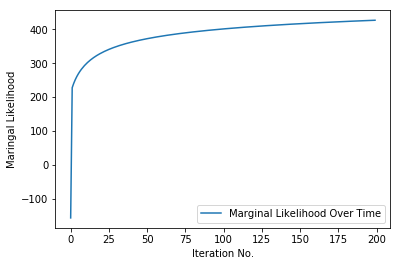

In [43]:
plt.plot(marginal_likelihood_nums, label='Marginal Likelihood Over Time');
plt.legend()
plt.ylabel('Maringal Likelihood')
plt.xlabel('Iteration No.');

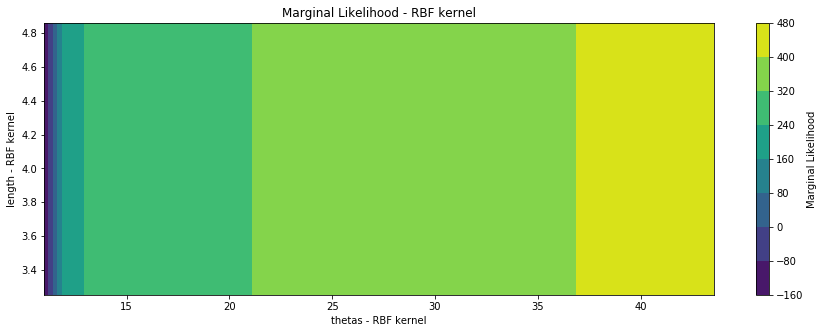

In [90]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
u = np.linspace(-1,1,100)
x,y = np.meshgrid(thetas,lengths)
z_ = np.meshgrid(np.array(marginal_likelihood_nums),np.array(marginal_likelihood_nums))
ax.set_xlabel('thetas - RBF kernel')
ax.set_ylabel('length - RBF kernel')
CS = ax.contourf(x,y,np.array(z_)[0,:,:])
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('Marginal Likelihood')
plt.title('Marginal Likelihood - RBF kernel');
#ax.legend()


In [78]:
z_ = np.meshgrid(np.array(marginal_likelihood_nums),np.array(marginal_likelihood_nums))

In [79]:
np.array(z_)[0,:,:].shape

(200, 200)

In [76]:
z.shape

(100, 100)

In [160]:
combos[np.argmax(demo_marginal_likelihoods)]

(2.0, 40.0)